In [1]:
from fish.ephys.ephys import load, chop_trials, estimate_onset
from fish.util.fileio import load_image
from glob import glob
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [166]:
matplotlib.rcParams['font.sans-serif'] = ['Arial']

In [2]:
def trigger_data(triggers, window, fnames, average=False):
    from fish.util.fileio import load_image
    from numpy import array
    
    ims_trial = []
    
    for ind, trig in enumerate(triggers):
        
        tr = []        
        for t_w in window:        
            tr.append(load_image(fnames[trig + t_w]))
        tr = array(tr)
        
        
        if (len(ims_trial) == 0) or not average:
            ims_trial.append(tr)
        if average:
            if ind == 0:
                ims_trial[0] = ims_trial[0].astype('float32') / len(triggers) 
            
            ims_trial[0] += tr.astype('float32') / len(triggers)
        
    if average:         
        return ims_trial[0]
    else:
        return array(ims_trial)

def get_roi(pqim, data):
    return pqim.roi.getArrayRegion(data, pqim.imageItem, axes=(1,2)).mean((1,2))

def unroll(v):
    if v.ndim == 4:
        return v.reshape(v.shape[0], v.shape[1] * v.shape[2], v.shape[3])
    elif v.ndim ==3:
        return v.reshape(v.shape[0] * v.shape[1], v.shape[2])
    
# Need this function to prevent pyqtgraph from leaking memory
def wipe_ims(pq):
    from numpy import zeros

    for iw in pq.images:
      iw.setImage(zeros((1,1))) #<- dummy 1x1 image
      iw.parent().close()
def axs_format(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    
def load_muy_mat(fname, head_name='data'):
    from h5py import File 
    data = {}
    with File(fname) as f: 
        for k in f[head_name].keys():
            data[k] = np.squeeze(f[head_name][k][:])
    return data

def triggered_behavior(triggers, window, swims):
    from numpy import array
    trig_ep = []
    for trig in triggers:
        trig_ep.append(swims[trig + window])
    return array(trig_ep)

def standard_clim(axes, clim_scaling=(1,1)):
    clim = np.array([ax.get_images()[0].get_clim() for ax in axes])
    clim = (clim.min() * clim_scaling[0], clim.max() * clim_scaling[1])
    [ax.get_images()[0].set_clim(clim) for ax in axes]

class roi_pq(object):
    def __init__(self, coords, values):
        self.coords = coords
        self.values = values
        
    def __repr__(self):
        return 'An roi with {0} points'.format(len(self.values[0]))

In [115]:
import sys
import json
dirs = {}
if sys.platform != 'win32':
    dirs['base'] = '/groups/ahrens/ahrenslab/FROM_TIER2/Yu/SPIM/active_datasets/20170228/fish4/20170228_4_1_gfaprgeco_hucgc_6dpf_shorttrials_20170228_185002/'
else:
    dirs['base'] = 'Z:/FROM_TIER2/Yu/SPIM/active_datasets/20170228/fish4/20170228_4_1_gfaprgeco_hucgc_6dpf_shorttrials_20170228_185002/'
dirs['ephys'] = dirs['base'] + 'ephys/'
dirs['raw'] = dirs['base'] + 'raw/'
dirs['proj'] = dirs['base'] + 'projections/'
dirs['output'] = 'C:\\Users\\bennettd\\Dropbox (HHMI)\\ngm\\figs\\'
from fish.image.vol import get_stack_freq
fs_im = get_stack_freq(dirs['raw'])[0]

with open(dirs['proj'] + 'metadata.json', 'r') as f:
    metadata = json.load(f)

fnames = glob(dirs['proj'] + 't*.tif')
fnames.sort()
print(len(fnames))

7200


In [4]:
%%time
# Optional: load projections
plr = slice(5000)
projs = np.array([load_image(f) for f in fnames[plr]])

Wall time: 3min 23s


In [5]:
import pyqtgraph as pq
%gui qt

In [6]:
im = pq.image(unroll(projs))

In [8]:
rois = {}

In [26]:
vals, coords = im.roi.getArrayRegion(unroll(projs), im.imageItem, axes=(1,2), returnMappedCoords=True)
rois['waist_g'] = roi_pq(coords, vals.mean((1,2)))

In [27]:
pl = pq.plot(rois['lc'].values)
pl.plot(rois['waist_g'].values, pen='m')

In [19]:
epdat = load_muy_mat(dirs['ephys'] + 'data.mat')
epdat_raw = load_muy_mat(dirs['ephys'] + 'rawdata.mat', head_name='rawdata')
swims = epdat['fltCh1'] + epdat['fltCh2']
cam = np.where(np.diff(epdat['frame']))[0][plr]

In [57]:
# columns 1 and 2 are the start and stop of stim period
# columns 3 and 4 are start and stop of swim
# the code in the last column of this array: 1 means fish gave up, 3 means fish did not give up
from scipy.io import loadmat
pause_start = np.squeeze(loadmat(dirs['ephys'] + 'pause_start.mat')['pause_start'])
trial_info = loadmat(dirs['ephys'] + 'trial_info.mat')['trial_info']

gu_inds = trial_info[np.where(trial_info[:,-1] == 1)[0],3]
#ngu_inds = pause_start
ngu_inds = np.unique(trial_info[np.where(trial_info[:,-1] == 3)[0],3])

minlen = min(map(len, (gu_inds, ngu_inds))) - 1

gu_inds = gu_inds[:minlen]
ngu_inds = ngu_inds[:minlen]

frames_gu = epdat['frame'][gu_inds].astype('int')
frames_ngu = epdat['frame'][ngu_inds].astype('int')

In [80]:
from scipy.stats import zscore
x_ep = np.arange(cam[0], cam[-1], 15)
pl = pl = pq.plot(x_ep, zscore(swims[x_ep]))
pl.plot(cam, 5 + zscore(rois['waist_g'].values), pen='m')
pl.plot(cam, 5 + zscore(rois['lc'].values), pen='g')
pl.plot(x_ep, 10 + zscore(epdat_raw['stimVelTotal'][x_ep]), pen='y')

In [58]:
window_im = np.arange(-10, 20)
trig_gu = trigger_data(frames_gu, window_im, fnames, average=True)
trig_ngu = trigger_data(frames_ngu, window_im, fnames, average=True)

from skimage.exposure import rescale_intensity
in_range = (26, 4136)
out_range = tuple(metadata['dff_lims'])
trig_gu = rescale_intensity(trig_gu, in_range=in_range, out_range=out_range)
trig_ngu = rescale_intensity(trig_ngu, in_range=in_range, out_range=out_range)

In [101]:
trig_gu_raw = trigger_data(frames_gu, window_im, fnames)
trig_ngu_raw = trigger_data(frames_ngu, window_im, fnames)

In [104]:
from scipy.stats import ttest_ind

In [107]:
pvals = ttest_ind(trig_gu_raw, trig_ngu_raw, axis=0)

In [111]:
pq.image(pvals.pvalue.min(1))

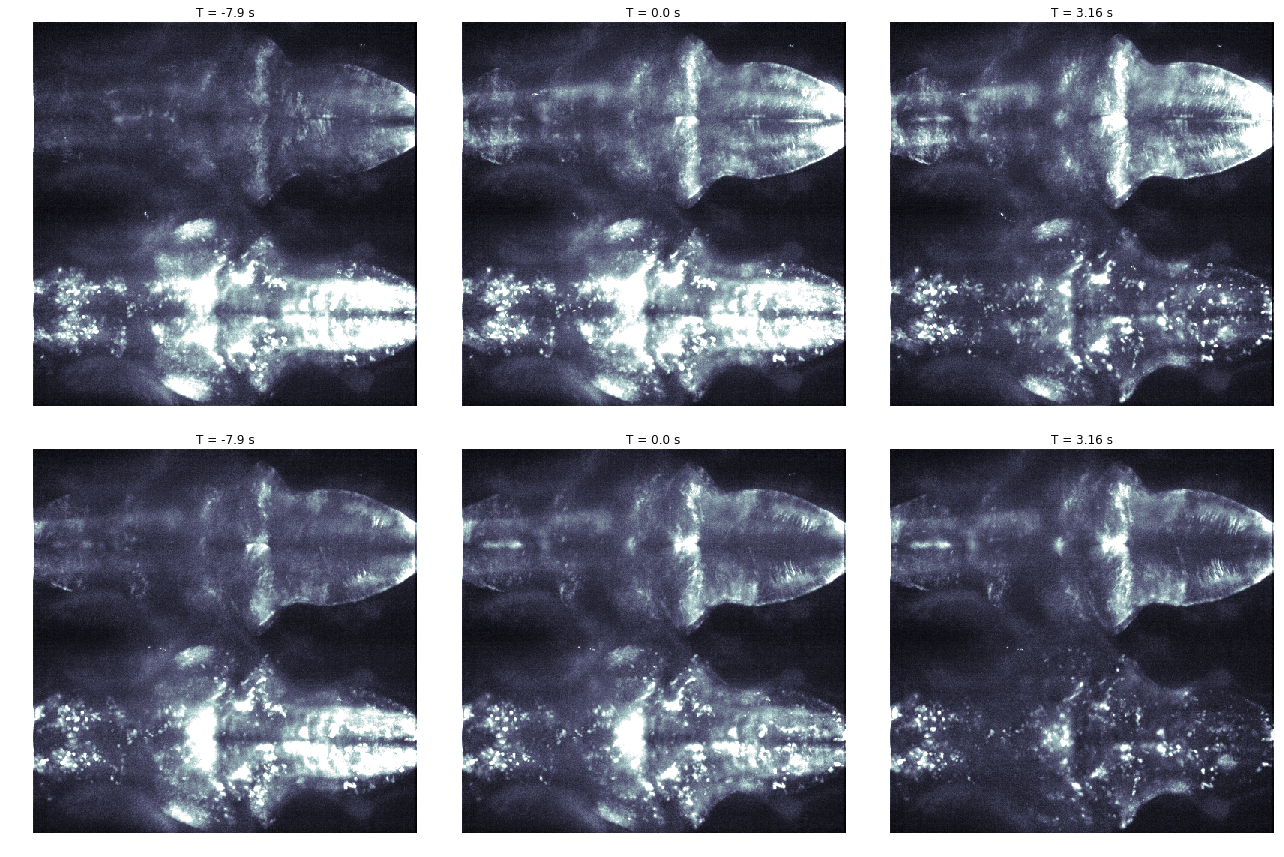

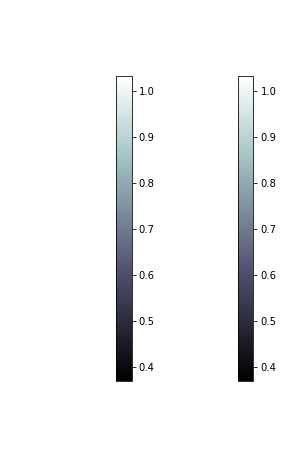

In [116]:
t_points = [5,10,12]
cmap='bone'
gamma = 1
fig, axs = plt.subplots(ncols=3, nrows =2, figsize=(18,12))
for ind,ax in enumerate(axs[0]):
    ax.imshow(trig_gu[t_points[ind]].max(0) ** gamma, cmap=cmap)
    ax.axis('off')
    ax.title.set_text(f'T = {window_im[t_points[ind]] * fs_im} s')
    
for ind,ax in enumerate(axs[1]):
    ax.imshow(trig_ngu[t_points[ind]].max(0) ** gamma, cmap=cmap)
    ax.axis('off')
    ax.title.set_text(f'T = {window_im[t_points[ind]] * fs_im} s')
standard_clim(axs.ravel(), clim_scaling=(1.1,.3))
plt.tight_layout()

plt.savefig(dirs['output'] + 'triggered_average.pdf')

fig, axs_cm = plt.subplots(ncols=2, figsize=(4,8))
plt.colorbar(axs[1][1].get_images()[0], ax = axs_cm[0])
plt.colorbar(axs[0][1].get_images()[0], ax = axs_cm[1])
[ax.axis('off') for ax in axs_cm]
plt.savefig(dirs['output'] + 'triggered_average_cbar.pdf')

In [130]:
def stackline(x_axis, array, axis, scale, **kwargs):
    for ind, val in enumerate(array):
        axis.plot(x_axis, val - ind * scale, **kwargs)
    axis.set_xlim(x_axis.min(), x_axis.max())

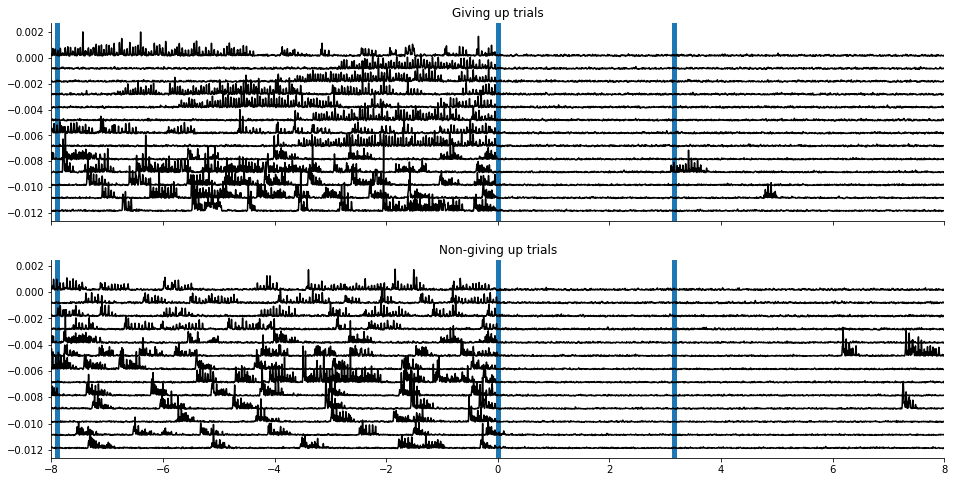

In [131]:
fig, axs = plt.subplots(nrows=2, figsize=(16,8), sharex=True)
window = np.arange(-8 * 6000, 8 * 6000)
x_axis_ep = window / 6000

triggers = gu_inds
trig_ep_gu = triggered_behavior(triggers, window, swims)
scale = .001

stackline(x_axis_ep, trig_ep_gu, axis=axs[0], scale=scale, color='k')
axs[0].title.set_text('Giving up trials')
[axs[0].axvline(window_im[t] * fs_im, zorder=0, linewidth=5) for t in t_points]

triggers = ngu_inds
trig_ep_ngu = triggered_behavior(ngu_inds, window, swims)
stackline(x_axis_ep, trig_ep_ngu, axis=axs[1], scale=scale, color='k')
    
axs[1].set_xlim(x_axis_ep[0], x_axis_ep[-1])    
axs[1].title.set_text('Non-giving up trials')
[axs_format(ax) for ax in axs]
[axs[-1].axvline(window_im[t] * fs_im, zorder=0, linewidth=5) for t in t_points]

plt.savefig(dirs['output'] + 'triggered_behavior.pdf')

In [185]:
from skimage.io import imsave
imsave(dirs['output'] + 'triggered_average_gu.tif', trig_gu.astype('float32'), compress=1)
imsave(dirs['output'] + 'triggered_average_ngu.tif', trig_ngu.astype('float32'), compress=1)

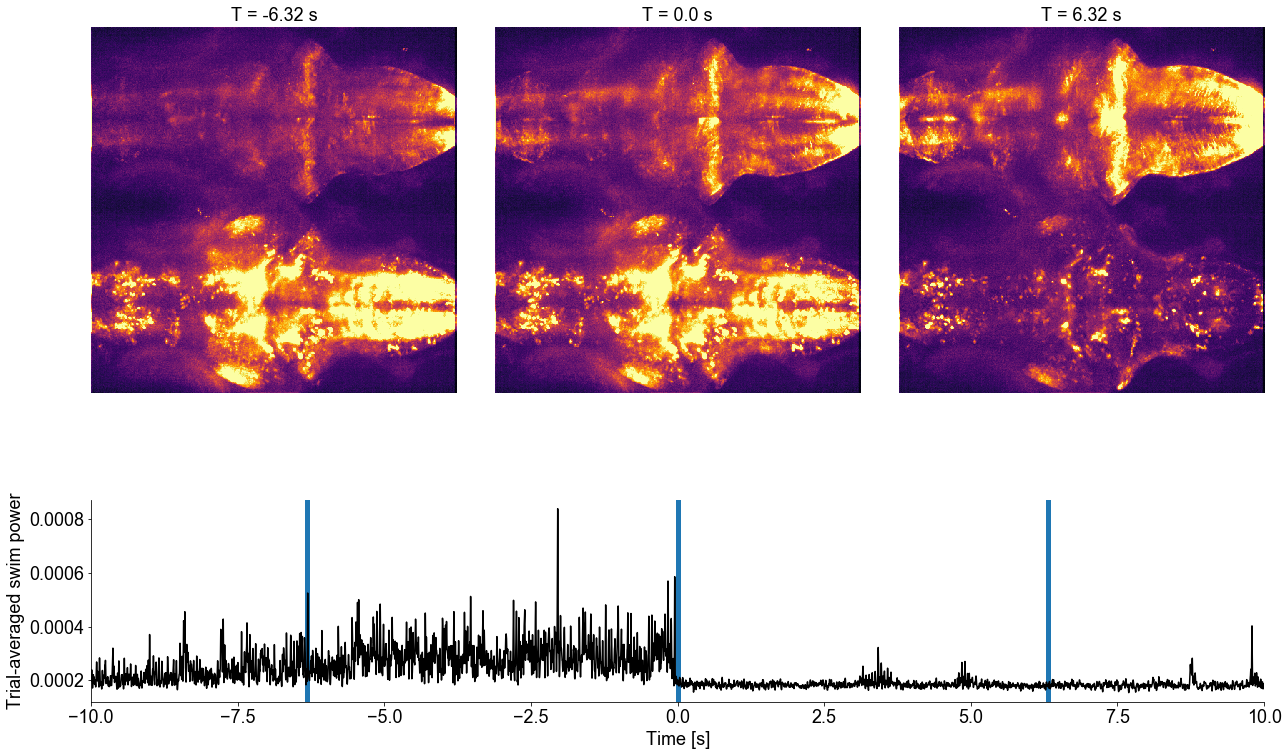

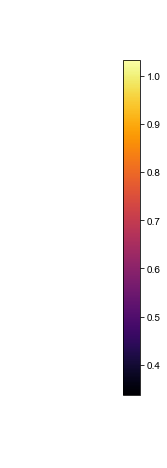

In [190]:
import matplotlib.gridspec as gridspec

t_points = [6, 10, 14]
vol = trig_gu
triggers = gu_inds

cmap='inferno'
gamma = 1

window_ep = np.arange(-10 * 6000, 10 * 6000)
x_axis_ep = window_ep / 6000

trig_ep_gu = triggered_behavior(triggers, window_ep, swims)
scale = .001

fig = plt.figure(figsize=(18,12))
gs = gridspec.GridSpec(2, 3, height_ratios=[3,1])
axs_ims = [plt.subplot(gs[0,t]) for t in range(len(t_points))]
axs_ts = plt.subplot(gs[1,:])

# plot images
for ind,ax in enumerate(axs_ims):
    ax.imshow(vol[t_points[ind]].max(0) ** gamma, cmap=cmap)
    ax.axis('off')
    ax.title.set_fontsize(18)
    ax.title.set_text(f'T = {window_im[t_points[ind]] * fs_im} s')    
standard_clim(axs_ims, clim_scaling=(1, .3))
# plot corresponding timeseries
axs_ts.plot(x_axis_ep, trig_ep_gu.mean(0), color='k')
axs_ts.set_xlim(x_axis_ep[0], x_axis_ep[-1])
axs_ts.set_ylabel('Trial-averaged swim power', fontsize=18)
axs_ts.set_xlabel('Time [s]', fontsize=18)
#stackline(x_axis_ep, trig_ep_gu, axis=axs_ts, scale=scale, color='k')

axs_ts.tick_params(axis='both', which='major', labelsize=18)
axs_ts.tick_params(axis='both', which='minor', labelsize=18)
[axs_ts.axvline(window_im[t] * fs_im, zorder=0, linewidth=5) for t in t_points]
axs_format(axs_ts)
plt.tight_layout()

plt.savefig(dirs['output'] + 'triggered_average_gu.pdf')

fig, axs_cm = plt.subplots(figsize=(2,8))
axs_cm.axis('off')
plt.colorbar(axs_ims[0].get_images()[0], ax = axs_cm)
plt.savefig(dirs['output'] + 'triggered_average_gu_cbar.pdf')